# Compulsory 3 - Erlend Risvik


## Imports and loading data

In [31]:
import pandas as pd
from pyspark.sql import SparkSession
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("SELECT * FROM fish_data_full").toPandas()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="lice_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("lice_data_full"))

lice_data = spark.sql("SELECT * FROM lice_data_full").toPandas()

In [9]:
fish_data.head()

,localityweekid,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isonland,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year
0,190827,NaN,False,False,False,False,False,True,False,True,...,False,False,69.881302,10753,19.434532,Karlsøy,1936,Strandmo,43,2015
1,140632,NaN,False,False,False,False,False,True,False,True,...,False,False,66.298866,13522,12.813833,Nesna,1828,Valvika,17,2015
2,913528,NaN,False,False,False,False,False,False,False,True,...,False,False,70.242447,34077,19.500000,Karlsøy,1936,Torsvåg II,25,2015
3,189850,NaN,False,False,False,False,False,True,False,True,...,False,False,68.868980,11414,15.301050,Øksnes,1868,Toften,19,2015
4,201349,0.4,False,False,False,False,True,True,False,True,...,False,False,60.885334,13567,5.461600,Masfjorden,1266,"Knappen,Solheim",2,2015


In [10]:
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187305,0.10,0.10,0.50,True,True,False,False,True,True,False,False,24175,9.2,42,2015
1,187281,0.00,0.02,0.13,False,False,False,False,True,True,False,False,24175,4.0,18,2015
2,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015
3,187271,0.00,0.00,0.00,False,False,False,False,True,True,False,False,24175,3.3,8,2015
4,187272,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.3,9,2015


## Pivoting

In [42]:
# We start by creating  a variable called a variable region, splitting Norway into three regions:
# South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude

fish_data['region'] = fish_data['lat'].apply(lambda x: 'South' if x < 63.81 else ('Middle' if x < 68.85 else 'North'))
fish_data[["lat", "region"]].head(10)

,lat,region
0,59.932133,South
1,70.385979,North
2,68.666382,Middle
3,65.708214,Middle
4,59.785851,South
5,66.118500,Middle
6,69.195900,North
7,66.113113,Middle
8,59.803150,South
9,60.234982,South


In [34]:
# Next, we pivot using week as category and avgAdultFemaleLice as value
lice_data.groupby("week", dropna = False).agg({"avgadultfemalelice": "mean"}).reset_index().head(52)

,week,avgadultfemalelice
0,1,NaN
1,2,0.00
2,3,0.00
3,4,0.00
4,5,NaN
5,6,0.00
6,7,NaN
7,8,0.00
8,9,NaN
9,10,0.00


In [51]:
# Next, we create a pivot table for categories hasPd and hasIla with values lat

fish_data.pivot_table(index = "haspd", columns = "hasila", values = "lat", aggfunc = "mean")

hasila,False,True
haspd,,
False,63.946201,67.401024
True,61.677021,63.141956


In [54]:
# Finally, we create a pivot table for week and region with values avgAdultFemaleLice

pivot = fish_data.pivot_table(columns = "region", index = "week", values = "avgadultfemalelice", aggfunc = "mean")
pivot

region,Middle,North,South
week,,,
1,0.157852,0.098125,0.257882
2,0.155034,0.140270,0.280702
3,0.172624,0.055584,0.284847
4,0.169366,0.053143,0.258397
5,0.169348,0.056842,0.281707
6,0.157710,0.054528,0.231207
7,0.168240,0.050800,0.192832
8,0.141694,0.063167,0.209759
9,0.134375,0.066780,0.201831


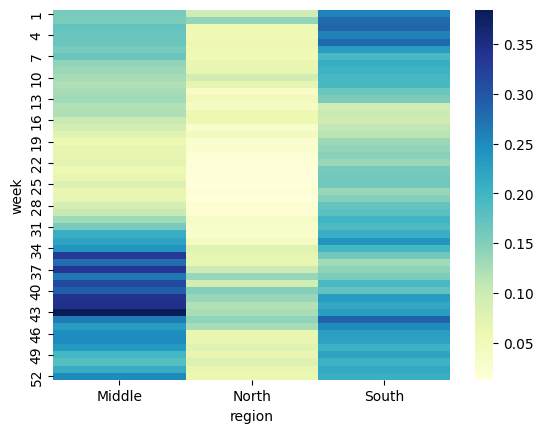

In [56]:
sns.heatmap(pivot, cmap = "YlGnBu")
plt.show()

- We can see from the first pivot that lice is most previlent in hot weather, i.e. when the the weeks inccrease towards summer, the lice count increases.
- The second table shows that where hasPD is False and hasIla is True, the average of this occurence is higher up in Norway than for the other cases. On the other hand, where hasPD is True and hasIla is False, this occurence happens more often in the south of Norway.
- Finally, the third table shows that:
    - South has high lice count at the beginning and end of year.
    - Middle has high lice count from middle of the year to the end of the year.
    - North has on average the lowest lice count compared to both of the other regions.
